In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a base
# 10.2.6

Base = automap_base()

# reflect the tables
# Use the Base class to reflect the database tables

Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
# 10.2.6

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Assign the demographics (station, measurement) class to a variable\
# 10.2.6

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
# 10.2.6

session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# Latest Date from measurement
# 10.3.2

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

column_measurement = inspector.get_columns('measurement')
column_station = inspector.get_columns('station')

column_measurement
#column_station

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

last_data_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_data_date

# Calculate the date one year from the last date in data set.

# strptime(date_string, format): Pases a string into a datetime object based on the format specified
# %Y Year(4 digits), %m Month(01 - 12), %d Day of the Month(01 - 31) 

# This allows the datetime module to be used, and its related functions like strptime and timedelta
from datetime import datetime, timedelta

formated_last_data_date = datetime.strptime(last_data_date, "%Y-%m-%d")

date_one_year_ago = formated_last_data_date - timedelta(days = 365)

print(date_one_year_ago)

2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
# All the dates since the date from a year ago
# 10.3.3

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_one_year_ago).all()

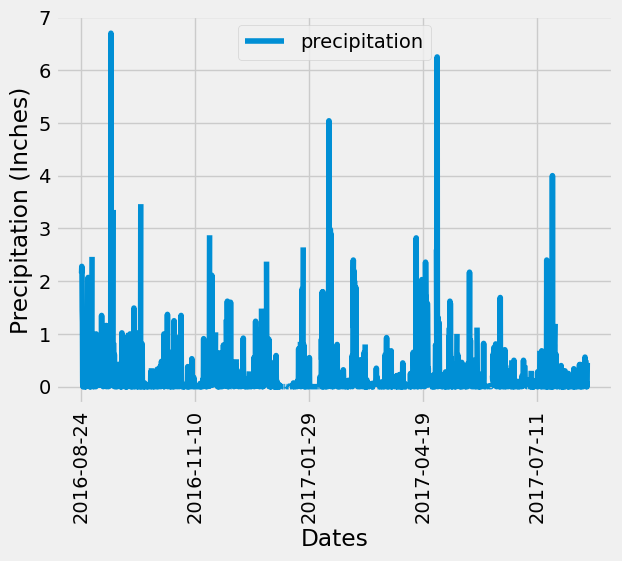

In [13]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns = ['date', 'precipitation'])

# Sort the dataframe by date

sorted_df = df.sort_values(by = 'date', ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data

sorted_df.plot(x = 'date', y = 'precipitation', rot = 90)
plt.ylabel('Precipitation (Inches)')
plt.xlabel('Dates')

plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data

#summary_stats = sorted_df['precipitation'].describe()

summary_stats_df = pd.DataFrame(sorted_df['precipitation'].describe())

summary_stats_df

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
# 10.3.1

stations_count = session.query(func.count(Station.id)).all()
stations_count

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# 10.3.1

stations_measurements_rows = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations_measurements_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# there is station row within measurements

temperatures = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)).all()

temperatures

[(53.0, 87.0, 73.09795396419437)]

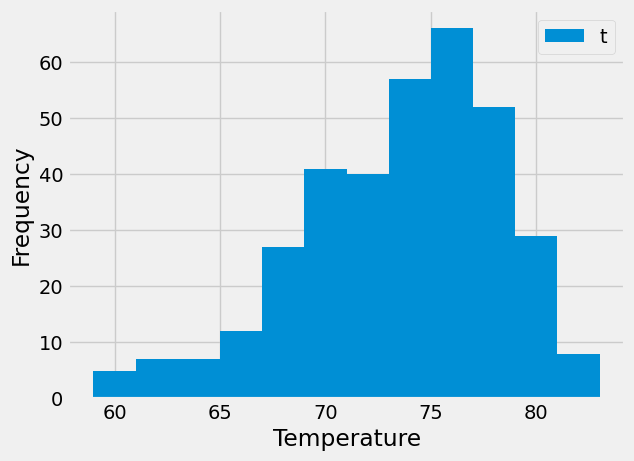

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# create new results to be used for the graph (tobs)

results_tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == stations_measurements_rows[0][0]).\
    filter(Measurement.date >= date_one_year_ago).all()

# Make the new dataframe for histogram

tobs_df = pd.DataFrame(results_tobs)

# Use Pandas Plotting with Matplotlib to plot the data into a histogram

tobs_histogram = tobs_df['tobs'].hist(bins = 12)

plt.legend('tobs')

plt.ylabel('Frequency')
plt.xlabel('Temperature')

plt.show()


# Close Session

In [19]:
# Close Session
session.close()